In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


# Load Libraries and Dataset

In [2]:
import os
import cv2
import shutil
import imutils
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import normalize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# IGNORING UNNECESSARRY WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

2024-08-24 06:10:16.978213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 06:10:16.978375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 06:10:17.151172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = '/kaggle/input/classification-dataset/healthy_and_tumor'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

LABELS = ['healthy', 'tumor']
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

In [4]:
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds()

# Helper Preprocessing Functions

The functions below will do the following:
* Load images and labels and return train,validation and test data in the form of numpy arrays
* Help to understand and visualise the data
* Shuffle and normalise data

In [5]:
def load_images_and_labels(base_dir, labels, color_mode='rgb'):
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    for label in labels:
        # Load training images
        train_dir = os.path.join(base_dir, 'train', label)
        for img_name in os.listdir(train_dir):
            img_path = os.path.join(train_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_train.append(img)
                y_train.append(labels.index(label))

        # Load validation images
        val_dir = os.path.join(base_dir, 'validation', label)
        for img_name in os.listdir(val_dir):
            img_path = os.path.join(val_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_val.append(img)
                y_val.append(labels.index(label))

        # Load test images
        test_dir = os.path.join(base_dir, 'test', label)
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_test.append(img)
                y_test.append(labels.index(label))

    # Convert lists to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

def print_data_shape(x_train, y_train, x_val, y_val, x_test, y_test):
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
def sample_images_224(x_train):
    images = [x_train[i] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
def display_sample_images(x, y, labels, num_samples=5):
    plt.figure(figsize=(20, 10))
    indices = np.random.choice(np.arange(x.shape[0]), num_samples, replace=False)
    for i, index in enumerate(indices):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(x[index], cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (Matplotlib)
        plt.title(f"Label: {labels[y[index]]}")
        plt.axis("off")
    plt.show()
    
# Shuffle the datasets
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    return x[indices], y[indices]
    
def data_normalization(x_test):    
    return x_test / 255.0

# Helper Functions for Model Training

The functions below will do the following:
* Plot learning curve during model training based on model history
* Evaluate the model on validation and test set
* Visualise models predictions on test data (qualitative analysis)
* Plot confusion matrix and classification report
* Run the model
* Save model after evaluation

In [6]:
def plot_training_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def evaluate_model(model, generator, steps, x_test, y_test):
    validation_loss, validation_acc = model.evaluate(generator, steps=steps)
    print(f"Validation loss: {validation_loss}")
    print(f"Validation accuracy: {validation_acc}")
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_acc}")
    
def plot_pred_imgs(number_images,x_test,y_test,model):
    # Choose some random images from the test set
    num_images = number_images
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)
    sample_images = x_test[random_indices]
    sample_labels_true = y_test[random_indices]

    # Predict labels for the sample images
    sample_predictions = model.predict(sample_images)
    sample_labels_pred = (sample_predictions > 0.5).astype(int).flatten()

    # Define class labels (assuming binary classification)
    class_labels = ['healthy', 'tumor']

    # Plot the sample images with true and predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"True: {class_labels[sample_labels_true[i]]}\nPred: {class_labels[sample_labels_pred[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_cm(model,x_test,y_test):
    # Assuming you have predictions on the test set already
    test_predictions = model.predict(x_test)
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred_classes)
    
    # Define class labels
    class_labels = ['healthy', 'tumor'] # healthy=0, tumor=1

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_class_report(model,x_test,y_test):
    # Assuming you have predictions on the test set already
    test_predictions = model.predict(x_test)
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

    # Define class labels
    class_labels = ['healthy', 'tumor']

    # Generate classification report
    report = classification_report(y_test, test_pred_classes, target_names=class_labels)

    print("Classification Report:\n", report)

def run_model(model,train_generator,steps_per_epoch,epochs,val_generator,validation_steps, callbacks,boolean=False):
    if boolean == True:
        history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks = [callbacks]
    )
    else:    
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=validation_steps
        )
    return history

def save_model(model, name):
    model.save(f'{name}.h5')

# Loading Pipeline

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = load_images_and_labels(base_dir, LABELS, color_mode=COLOR_MODE)

x_train, y_train = shuffle_data(x_train, y_train)
x_val, y_val = shuffle_data(x_val, y_val)
x_test, y_test = shuffle_data(x_test, y_test)

x_test = data_normalization(x_test)
print_data_shape(x_train, y_train, x_val, y_val, x_test, y_test)

x_train shape: (2100, 224, 224, 3)
y_train shape: (2100,)
x_val shape: (450, 224, 224, 3)
y_val shape: (450,)
x_test shape: (450, 224, 224, 3)
y_test shape: (450,)


# Apply Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

# Create a generator for the validation data (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

# Models

Two models will be built which will vary in the number of layers and tuning. The first is a baseline model and the next is more complex model with extra layers and kernel_initializer. The tuned model will be run for 30 and 50 epochs.

In [9]:
def model_1(INPUT_SHAPE):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=INPUT_SHAPE))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3),activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.summary()
    return model

def model_2(INPUT_SHAPE):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=INPUT_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [10]:
baseline_model = model_1(INPUT_SHAPE)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,345 (10.78 MB)

 Trainable params: 2,825,345 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
tuned_model = model_2(INPUT_SHAPE)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
tuned_model_50 = model_2(INPUT_SHAPE)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation

In [14]:
baseline_model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001),metrics=['acc'])
tuned_model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001),metrics=['acc'])
tuned_model_50.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001),metrics=['acc'])

# Callbacks

In [35]:
model1_path = '/kaggle/working/model1.keras'
model2_path = '/kaggle/working/model2.keras'

mc = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [es]

# Model Training

In [16]:
baseline_history = run_model(baseline_model,train_generator,100,30,val_generator,50,callbacks)

Epoch 1/30


2024-07-24 06:05:31.059953: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-07-24 06:05:31.060006: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-07-24 06:05:31.060016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-07-24 06:05:31.060027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-07-24 06:05:31.060035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-07-24 06:05:31.060044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-07-24 06:05:31.060052: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-07-24 06:05:31.060060: E 

  1/100 ━━━━━━━━━━━━━━━━━━━━ 15:26 9s/step - acc: 0.4375 - loss: 0.6938

I0000 00:00:1721801135.590845    1144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 22/100 ━━━━━━━━━━━━━━━━━━━━ 25s 327ms/step - acc: 0.4734 - loss: 0.6999

2024-07-24 06:05:43.287127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.63812, expected 5.86815
2024-07-24 06:05:43.287182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.57545, expected 5.80549
2024-07-24 06:05:43.287192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.58905, expected 5.81908
2024-07-24 06:05:43.287200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.3889, expected 5.61894
2024-07-24 06:05:43.287208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23839, expected 5.46843
2024-07-24 06:05:43.287217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.97291, expected 4.20294
2024-07-24 06:05:43.287225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.35322, expected 4.58326
2024-07-24 06:05:43.287233: E external/local_xla/xla/

 65/100 ━━━━━━━━━━━━━━━━━━━━ 12s 358ms/step - acc: 0.4929 - loss: 0.6948

2024-07-24 06:05:59.423953: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.4831, expected 2.95098
2024-07-24 06:05:59.424017: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 4.12173, expected 3.58961
2024-07-24 06:05:59.424027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.27148, expected 3.73936
2024-07-24 06:05:59.424035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 3.80207, expected 3.26995
2024-07-24 06:05:59.424043: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 3.95449, expected 3.42237
2024-07-24 06:05:59.424052: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 85: 4.14698, expected 3.61486
2024-07-24 06:05:59.424060: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 3.99831, expected 3.46619
2024-07-24 06:05:59.424078: E external/local_xla

100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 246ms/step - acc: 0.5070 - loss: 0.6930 - val_acc: 0.5000 - val_loss: 0.6806
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - acc: 0.5970 - loss: 0.6801 - val_acc: 0.6822 - val_loss: 0.6384
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - acc: 0.6355 - loss: 0.6632 - val_acc: 0.7333 - val_loss: 0.6063
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - acc: 0.6611 - loss: 0.6368 - val_acc: 0.7133 - val_loss: 0.5674
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - acc: 0.6839 - loss: 0.6182 - val_acc: 0.7889 - val_loss: 0.5147
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - acc: 0.7177 - loss: 0.5827 - val_acc: 0.7178 - val_loss: 0.5689
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - acc: 0.7175 - loss: 0.5740 - val_acc: 0.7867 - val_loss: 0.4893
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - acc: 0.7399 - loss: 0.5510 - val_acc: 0.6889 - val_loss: 0.5356
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s

In [18]:
tuned_history = run_model(tuned_model,train_generator,100,30,val_generator,50,callbacks)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - acc: 0.5512 - loss: 0.7406 - val_acc: 0.7156 - val_loss: 0.6117
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.6357 - loss: 0.6486 - val_acc: 0.6289 - val_loss: 0.6095
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.6910 - loss: 0.6090 - val_acc: 0.7689 - val_loss: 0.5096
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.7280 - loss: 0.5814 - val_acc: 0.8000 - val_loss: 0.4537
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - acc: 0.7410 - loss: 0.5373 - val_acc: 0.8200 - val_loss: 0.4211
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.7661 - loss: 0.5135 - val_acc: 0.8333 - val_loss: 0.4062
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - acc: 0.7836 - loss: 0.4879 - val_acc: 0.8533 - val_loss: 0.3716
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.8002 - loss: 0.4847 - val_acc: 0.8378 - val_loss: 0.3670
Epoch 9/30
100/100 ━━━━━━━━━━━━━

In [39]:
tuned_history_50 = run_model(tuned_model_50,train_generator,100,50,val_generator,50,callbacks,True)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - acc: 0.5369 - loss: 0.8808 - val_acc: 0.6733 - val_loss: 0.6138
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - acc: 0.6396 - loss: 0.6414 - val_acc: 0.7356 - val_loss: 0.5402
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.7079 - loss: 0.5875 - val_acc: 0.7733 - val_loss: 0.4810
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - acc: 0.7417 - loss: 0.5707 - val_acc: 0.7956 - val_loss: 0.4462
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - acc: 0.7368 - loss: 0.5471 - val_acc: 0.8133 - val_loss: 0.4233
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - acc: 0.7627 - loss: 0.5321 - val_acc: 0.8289 - val_loss: 0.4028
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - acc: 0.7561 - loss: 0.5015 - val_acc: 0.8378 - val_loss: 0.3783
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - acc: 0.7689 - loss: 0.4991 - val_acc: 0.8333 - val_loss: 0.3739
Epoch 9/50
100/100 ━━━━━━━━━━━━━

# Model Evaluation

## Learning curves

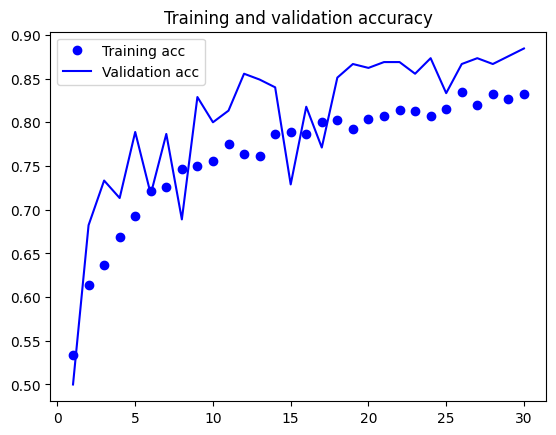

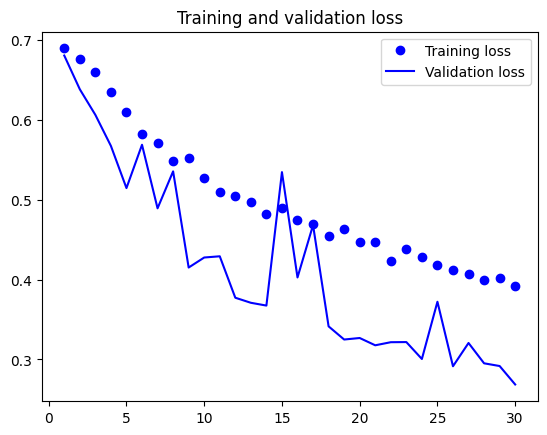

In [19]:
plot_training_curve(baseline_history)

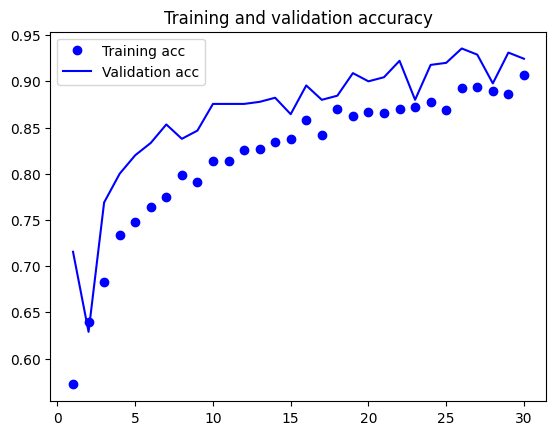

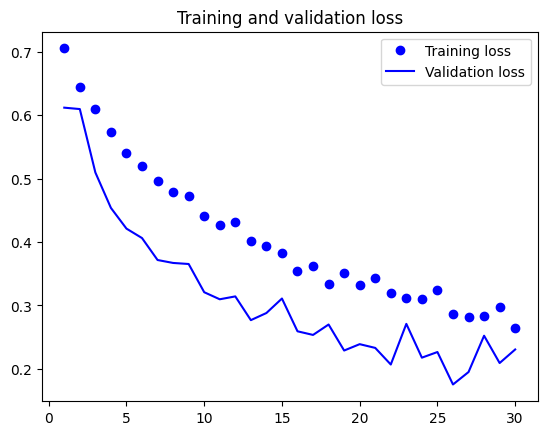

In [21]:
plot_training_curve(tuned_history)

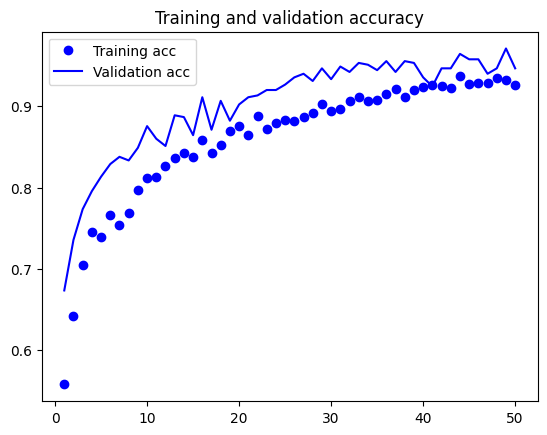

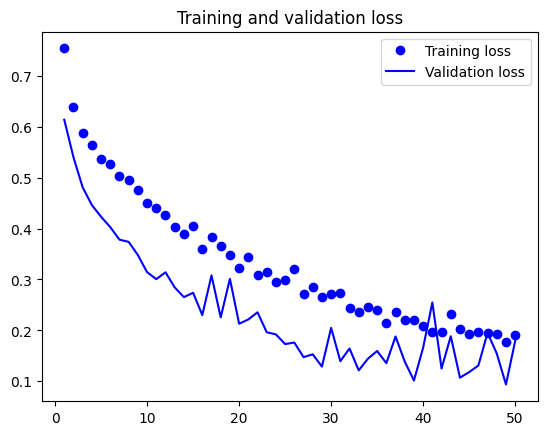

In [40]:
plot_training_curve(tuned_history_50)

## Evaluation on validation and test set

In [22]:
evaluate_model(baseline_model,val_generator,50,x_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8864 - loss: 0.2609 
Validation loss: 0.2687160074710846
Validation accuracy: 0.8844444155693054
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8755 - loss: 0.2784
Test loss: 0.27998971939086914
Test accuracy: 0.8777777552604675


In [24]:
evaluate_model(tuned_model,val_generator,50,x_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9234 - loss: 0.2220 
Validation loss: 0.23235507309436798
Validation accuracy: 0.9222221970558167
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9227 - loss: 0.2223
Test loss: 0.21169477701187134
Test accuracy: 0.9244444370269775


In [41]:
evaluate_model(tuned_model_50,val_generator,50,x_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9733 - loss: 0.0856 
Validation loss: 0.09130816161632538
Validation accuracy: 0.9733333587646484
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9638 - loss: 0.0936
Test loss: 0.08820363879203796
Test accuracy: 0.9733333587646484


## Qualitative analysis of best model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


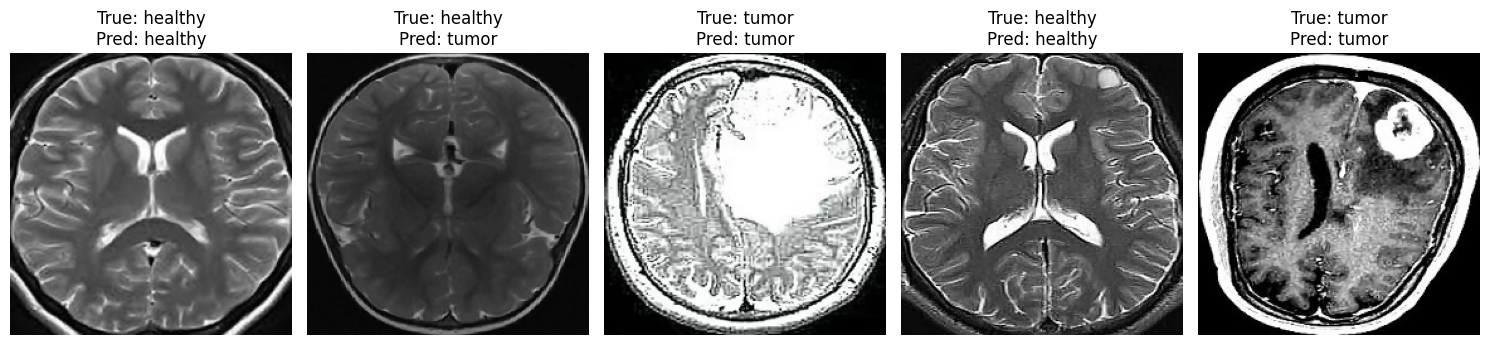

In [42]:
plot_pred_imgs(5,x_test,y_test,tuned_model_50)

## Confusion matrices

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


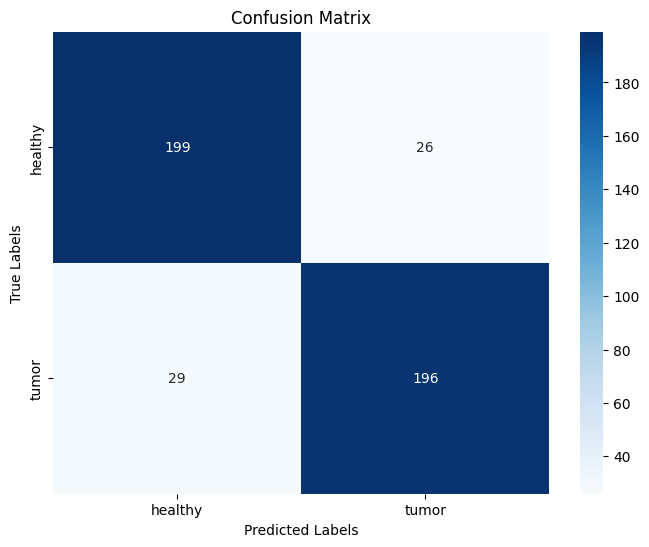

In [28]:
plot_cm(baseline_model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


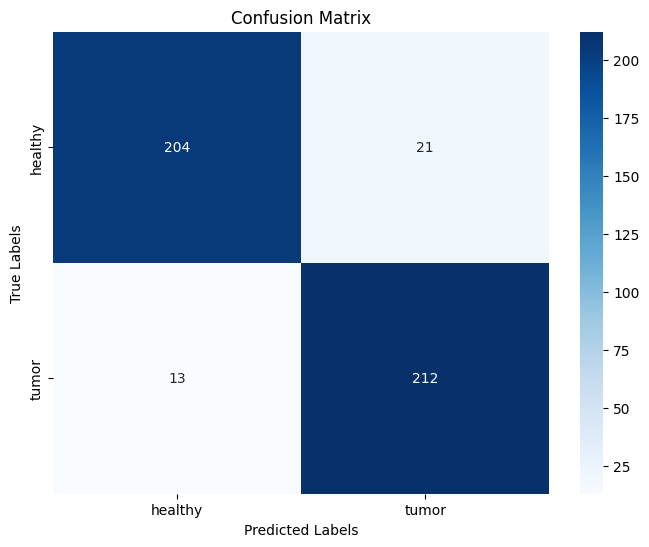

In [26]:
plot_cm(tuned_model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


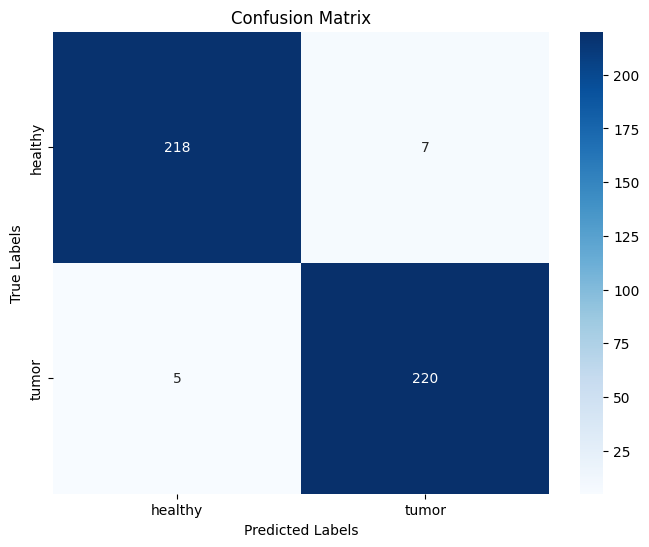

In [43]:
plot_cm(tuned_model_50,x_test,y_test)

## Classification reports

In [30]:
plot_class_report(baseline_model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.87      0.88      0.88       225
       tumor       0.88      0.87      0.88       225

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450



In [27]:
plot_class_report(tuned_model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.94      0.91      0.92       225
       tumor       0.91      0.94      0.93       225

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.92      0.92       450



In [44]:
plot_class_report(tuned_model_50,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.98      0.97      0.97       225
       tumor       0.97      0.98      0.97       225

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



# Save Model

In [32]:
save_model(baseline_model,'classification_baseline')

In [33]:
save_model(tuned_model,'classification_tuned')

In [45]:
save_model(tuned_model_50,'classification_tuned_50')

# Classification System Pipeline

## Load model

In [46]:
# Load your trained model
model = load_model('/kaggle/working/classification_tuned_50.h5')

### The code is made more robust and clean adding modifications to the code in 'classification_best_model.ipynb'.

In [47]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

def process_img(img):
    img = crop_brain_contour(img,False)
    img = cv2.resize(img,dsize=(224, 224),interpolation=cv2.INTER_CUBIC)
    img = cv2.bilateralFilter(img, 2, 50, 50)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

def make_predictions(model,img):
    # Make prediction
    predictions = model.predict(img)

    # Convert to binary predictions
    pred = (predictions > 0.5).astype(int).flatten()

    # Output the result
    if pred[0] == 1:
        print('Tumor detected')
    else:
        print('No tumor detected')

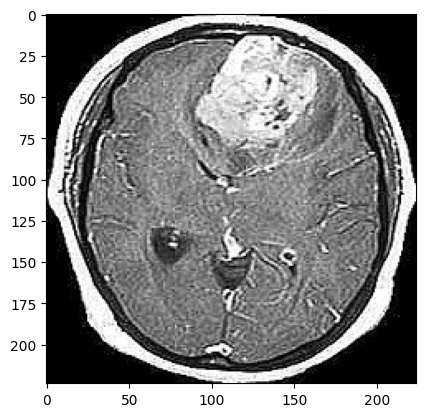

In [93]:
pred_img = cv2.imread('/kaggle/input/classification-dataset/healthy_and_tumor/test/tumor/y1191.jpg')
plt.imshow(pred_img)

## Process image

In [94]:
pred_img = process_img(pred_img)

In [95]:
pred_img.shape

(1, 224, 224, 3)

## Make predictions

In [96]:
make_predictions(model, pred_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Tumor detected


# Code used for plotting model architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# Define your model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Generate and save the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)